In [4]:
import numpy as np

from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits.data, digits.target

# Question 1

Dans cette partie on explore la taille et le type des données, on se remémore comment sélectionner seulement les élements d'une classe donnée, etc.

In [5]:
X.ndim

2

In [6]:
X.shape

(1797, 64)

In [7]:
X.dtype

dtype('float64')

In [8]:
y.ndim, y.dtype

(1, dtype('int64'))

In [9]:
X.shape

(1797, 64)

In [10]:
X0 = X[y == 0, :]
X0.shape

(178, 64)

# Question 2

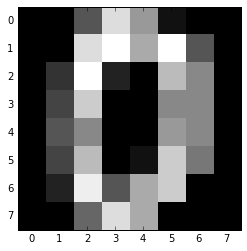

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.imshow(np.reshape(X[0], (8, 8)),
                 interpolation='nearest', cmap=plt.cm.gray)

# Question 3

In [12]:
classes = np.unique(y)
n_classes = classes.size
print(n_classes)

10


# Question 4

In [13]:
n, p = X.shape
mus = np.empty((n_classes, p), dtype=float)
sigma2s = np.empty((n_classes, p), dtype=float)
for k in range(n_classes):
    Xk = X[y == k]
    mus[k] = np.mean(Xk, axis=0)
    sigma2s[k] = np.var(Xk, axis=0)


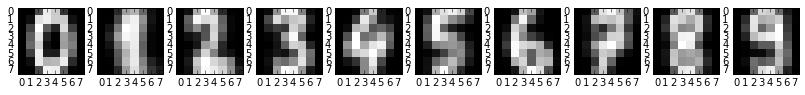

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(14, 2))

for k in range(n_classes):
    axes[k].imshow(np.reshape(mus[k], (8, 8)),
                     interpolation='nearest', cmap=plt.cm.gray)

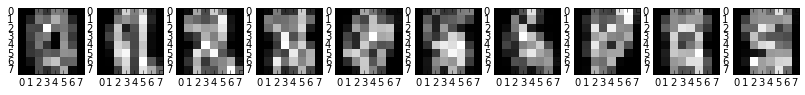

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(14, 2))
for k in range(n_classes):
    axes[k].imshow(np.reshape(sigma2s[k], (8, 8)),
                     interpolation='nearest', cmap=plt.cm.gray)

# Question 5

StandardScaler permet de normaliser chaque attribut pour que sa moyenne et sa variance sur le jeu de données soient respective 0 et 1. De manière générale, il est important et recommandé de normaliser les attributs avant d'entraîner des classifieurs pour éviter un biais en faveur des attributs qui prennent de grandes valeurs.

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Question 6

Dans cette question, on va simplement apprendre nos classifieurs sur toutes nos données et afficher le taux de prédictions correctes sur les données d'apprentissage. On va également afficher les hyperparamètres pour chaque classifieur, qui sont pour l'instant ceux par défaut. On remarquera par exemple que si on ne lui indique pas autrement, l'arbre de décision par défaut n'a pas de profondeur maximale ni d'autre critère d'arrêt : il va donc continuer jusqu'à ce qu'il classifie parfaitement les données d'apprentissage.

## Naive Bayes

In [17]:
from sklearn.naive_bayes import GaussianNB
clf_NB = GaussianNB()
clf_NB.fit(X_std, y)
print(clf_NB)
clf_NB.score(X_std, y)

GaussianNB()


0.79966611018363942

## Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
clf_logreg = LogisticRegression()
clf_logreg.fit(X_std, y)
print(clf_logreg)
clf_logreg.score(X_std, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


0.98720089037284364

## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
clf_tree = DecisionTreeClassifier()
clf_tree.fit(X_std, y)
print(clf_tree)
clf_tree.score(X_std, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


1.0

On observe ainsi qu'avec les hyperparamètres par défaut, l'arbre de décision est capable de mieux approcher les données d'apprentissage que la régression logistique, qui elle même est plus souple que le Naive Bayes (le modèle le plus simple).

# Question 7

Comme on l'a vu en cours, regarder l'erreur en apprentissage n'est pas un bon moyen pour évaluer la performance en généralisation d'un modèle. Pour cela, il faut utiliser un ensemble de validation disjoint de celui de l'ensemble d'apprentissage. On peut mettre en place différentes stratégies de validation, comme la validation croisée par exemple. C'est ce que l'on va voir dans la suite.

# Question 8

Le principe générale de l'apprentissage statistique est que, pour une classe de modèles fixée, plus on voit de données en apprentissage, plus on va bien généraliser à de nouvelles données. On s'attend donc à ce que le score en validation du modèle augmente avec la taille de l'ensemble utilisé pour l'apprendre.

# Question 9

On commence par se familiariser avec l'utilisation de la fonction `cross_val_score`. Voici comment faire un 3-fold cross validation sur nos données. On le fait sur le modèle de régression logistique.

In [17]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(clf_logreg, X_std, y, cv=3, scoring='accuracy')
print(scores)

[ 0.92358804  0.93823038  0.90604027]


On obtient ainsi 3 scores de validation, un pour chaque fold. On peut alors moyenner pour avoir le score de validation final, et calculer aussi la variance sur les folds.

In [18]:
print np.mean(scores), np.std(scores)

0.922619564099 0.0131593906453


Ci-dessous, on fait un rapide test pour voir comment évolue l'erreur de validation. Par simplicité, on ne fera pas ici de validation croisée mais un seul découpage de nos données en un ensemble de validation (les 500 premiers points) et d'apprentissage (le reste).

In [19]:
X_valid = X_std[:500]
X_train = X_std[500:]
y_valid = y[:500]
y_train = y[500:]
print(X_valid.shape)
print(X_train.shape)

(500, 64)
(1297, 64)


On va maintenant faire varier la taille de l'ensemble d'apprentissage (de 100 à 1200 par pas de 100), apprendre un modèle pour chaque taille, calculer l'erreur sur l'ensemble de validation et tracer la courbe. On fait cela pour les 3 types de modèles utilisés précédemment.

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]


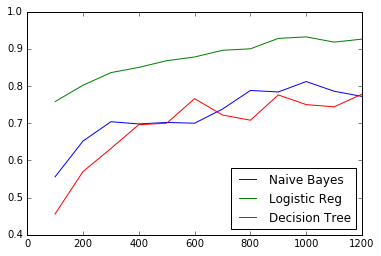

In [20]:
n_train_samples = range(100, len(X_train), 100)
print(n_train_samples)

scores = np.empty(len(n_train_samples))
for k, n_train in enumerate(n_train_samples):
    clf_NB.fit(X_train[:n_train], y_train[:n_train])
    scores[k] = clf_NB.score(X_valid, y_valid)

plt.plot(n_train_samples, scores, label='Naive Bayes')

scores = np.empty(len(n_train_samples))
for k, n_train in enumerate(n_train_samples):
    clf_logreg.fit(X_train[:n_train], y_train[:n_train])
    scores[k] = clf_logreg.score(X_valid, y_valid)

plt.plot(n_train_samples, scores, label='Logistic Reg')

scores = np.empty(len(n_train_samples))
for k, n_train in enumerate(n_train_samples):
    clf_tree.fit(X_train[:n_train], y_train[:n_train])
    scores[k] = clf_tree.score(X_valid, y_valid)

plt.plot(n_train_samples, scores, label='Decision Tree')

plt.legend(loc=4)

On remarque en effet que pour chaque modèle, le score en validation du modèle augmente avec la taille de l'ensemble d'apprentissage (note: les courbes sont un peu "bruitées" car on ne moyenne pas sur plusieurs tirages, comme on le fera dans la suite afin d'obtenir des courbes plus lissées). On remarque aussi que les arbres de décisions, malgré leur capacité à classifier parfaitement l'ensemble d'apprentissage, généralisent assez mal (ils sur-apprennent) par rapport à une régression logistique par exemple.

# Question 10

Plus la taille de l'ensemble d'apprentissage est grand, plus il est difficile de bien classifier. On s'attend donc à ce que le score sur l'ensemble d'apprentissage baisse avec la taille de cet ensemble.

# Question 11-12

On va vérifier cela à l'aide de la fonction `plot_learning_curve`. On donne à cette fonction une méthode de validation : ici on utilisera `ShuffleSplit` qui permet de moyenner sur plusieurs ensembles de train/validation générés aléatoirement (ci-dessous, on en génère `n_iter=50`, à réduire si c'est trop long) avec une proportion train/validation donnée (ci-dessous, `test_size=0.2` ce qui veut dire que l'ensemble de validation est composé de 20% des exemples).

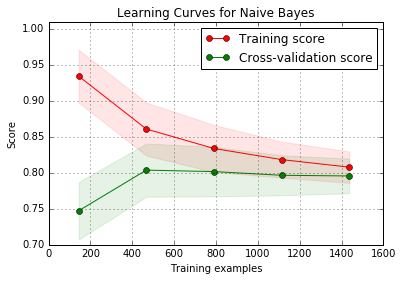

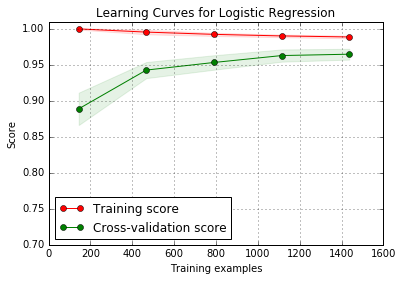

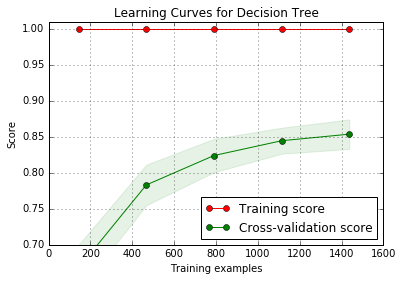

In [21]:
from learning_curve import plot_learning_curve
from sklearn import cross_validation

cv = cross_validation.ShuffleSplit(X_std.shape[0], n_iter=50, test_size=0.2, random_state=0)

title = "Learning Curves for Naive Bayes"
plot_learning_curve(clf_NB, title, X_std, y, ylim=(0.7, 1.01), cv=cv)

title = "Learning Curves for Logistic Regression"
plot_learning_curve(clf_logreg, title, X_std, y, ylim=(0.7, 1.01), cv=cv)

title = "Learning Curves for Decision Tree"
plot_learning_curve(clf_tree, title, X_std, y, ylim=(0.7, 1.01), cv=cv)

plt.show()

On remarque premièrement qu'en effet, le score en apprentissage baisse avec la taille de l'ensemble d'apprentissage, tandis que l'erreur en validation augmente comme observé en Question 9.

On peut tirer plusieurs enseignements intéressants de ces courbes :
- Pour le classifieur Naive Bayes, on voit que le score en validation se stabilise rapidement (autour de 0.80 avec 500 exemples). L'erreur en apprentissage converge elle aussi rapidement vers le score en validation. Ceci indique que ce modèle est sans doute trop "simple" (faible variance car quand S varie via n, le score de validation ne bouge pas et donc le classifieur est insensible aux données d'apprentissage S, et grand biais car le score d'apprentissage est faible) car le score en validation plafonne avec peu de données. C'est une incitation à utiliser une famille de modèles plus flexibles.
- Avec la régression logistique, qui apprend aussi un classifieur linéaire mais avec davantage de souplesse, on obtient des résultats très satisfaisants : on parvient à classifier les données d'apprentissage presque parfaitement, tout en ayant un score de validation élevé même pour les ensembles d'apprentissage de petite taille. Avec un ensemble d'apprentissage de taille 1400, on obtient un score en validation d'environ 0.97, ce qui est très élevé. Pour ce jeu de données, la régression logistique nous donne donc un bon compromis biais/variance.
- Enfin, l'arbre de décision classifie parfaitement l'ensemble d'apprentissage quelle que soit sa taille, comme on l'a vu en Question 6. Parallèlement, ses scores en validation sont faibles par rapport à la régression logistique (pas plus de 0.85), ce qui indique clairement un sur-apprentissage (overfitting). On est donc ici dans le cas de faible biais mais grande variance. C'est une incitation à considérer une famille de modèle plus simple, par exemple en limitant la profondeur maximale de l'arbre appris.

On compare maintenant avec un modèle de type Support Vector Machines (SVM) que l'on étudiera dans un prochain cours. Il s'agit d'un classifieur nonlinéaire.

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.01,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


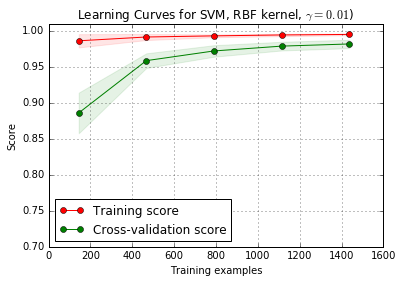

In [22]:
from sklearn.svm import SVC

title = "Learning Curves for SVM, RBF kernel, $\gamma=0.01$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = cross_validation.ShuffleSplit(X_std.shape[0], n_iter=50, test_size=0.2, random_state=0)
clf_SVM = SVC(gamma=0.01)
print(clf_SVM)
plot_learning_curve(clf_SVM, title, X_std, y, (0.7, 1.01), cv=cv)

plt.show()


On obtient ici des résultats légèrement meilleurs qu'avec la régression logistique. Il faut néanmoins garder à l'esprit que l'apprentissage et la prédiction avec ce modèle non linéaire sont plus coûteux qu'avec la régression logistique. En pratique, ce coût de calcul est aussi à prendre en compte dans le choix du modèle.

# Question 13

On va maintenant utiliser la validation croisée (10-fold cross validation) pour sélectionner les hyperparamètres. On va illustrer cette approche sur le modèle d'arbre de décision, où on va s'intéresser au paramètre de profondeur maximale de l'arbre (`max_depth`).

[ 0.17561111  0.45533333  0.67161111  0.85183333  0.85411111  0.85505556
  0.85561111  0.85344444  0.85316667  0.85305556  0.85555556  0.85627778
  0.85344444  0.85477778]


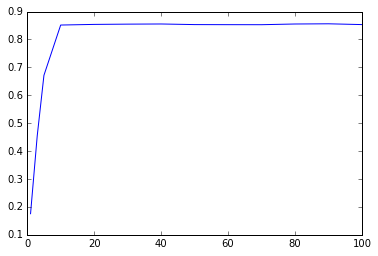

In [25]:
max_depth = [1, 3, 5, 10, 20, 30, 40, 50,60,70,80,90,100, None]
cv = cross_validation.ShuffleSplit(X_std.shape[0], n_iter=50, test_size=0.2, random_state=0)
scores = np.empty(len(max_depth))
for k, d in enumerate(max_depth):
    clf_tree = DecisionTreeClassifier(max_depth=d)
    scores[k] = np.mean(cross_validation.cross_val_score(clf_tree, X_std, y, cv=cv, scoring='accuracy'))

print(scores)
plt.plot(max_depth, scores)

On remarque que l'on peut améliorer très légèrement le score en validation en choisissant une profondeur maximale bornée. Mais cela ne suffit pas pour approcher les scores de la régression logistique par exemple. En fait, les arbres restent trop instables.

# Question 14

Pour remédier à ce problème, on va expérimenter avec les forêts aléatoires. On va garder une profondeur d'arbre non bornée et faire varier le nombre d'arbres dans la forêt. Chaque arbre de la forêt est construit sur un ensemble d'apprentissage construit par bootstrap, et on introduit également de l'aléatoire sur le choix des séparations, en considérant à chaque noeud l'arbre un sous-ensemble aléatoire des features (par défaut, on sélectionne un nombre de features égal à la racine carrée du nombre total de features). Pour prédire le label d'un exemple, on calcule la prédiction de chaque arbre de la forêt, et on choisit la classe la plus suivant prédite (vote majoritaire).

[ 0.771       0.91133333  0.95211111  0.96672222  0.97361111  0.97555556]


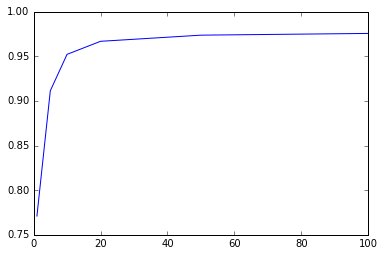

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation

n_arbres = [1, 5, 10, 20, 50, 100]
cv = cross_validation.ShuffleSplit(X_std.shape[0], n_iter=50, test_size=0.2, random_state=0)
scores = np.empty(len(n_arbres))
for k, n_estimators in enumerate(n_arbres):
    clf_forest = RandomForestClassifier(n_estimators=n_estimators)
    scores[k] = np.mean(cross_validation.cross_val_score(clf_forest, X_std, y, cv=cv, scoring='accuracy'))

print(scores)
plt.plot(n_arbres, scores)

On observe très clairement qu'une forêt aléatoire permet d'atténuer fortement le côté instable (faible biais, grande variance) des arbres, et ceci sans avoir besoin ici de limiter la profondeur maximale des arbres qui la composent. Plus la forêt contient d'arbres, plus le score en validation est élevé. On atteint ici des scores en validation similaires (voire légèrement supérieurs) à ceux obtenus avec la régression logistique.